In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd '/content/gdrive/MyDrive/Capstone_CV_Project/final_submission/locolization_part'

/content/gdrive/.shortcut-targets-by-id/19YhQZjFpRth4wLguvjLLzxep29Dos8O5/Capstone_CV_Project/final_submission/locolization_part


In [ ]:
import tensorflow
tensorflow.__version__

'2.8.2'

In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from os.path import join
from matplotlib import pyplot as plt
from cv2 import rectangle
import cv2
import matplotlib.patches as patches
import pydicom


import pandas as pd
from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model

import cv2
import tensorflow as tf
import tensorflow
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input 

import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

import re

import os
# Initialize the random number generator
# import random
# random.seed(0)
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
device_name = tf.test.gpu_device_name()
device_name = device_name.replace('/device:','/')
strategy = tf.distribute.MirroredStrategy(devices=[device_name])
strategy

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


#### Reading the data

In [ ]:
base_file_path = os.getcwd()

#paths for dataset info
train_data = pd.read_csv(os.path.join(base_file_path,
                                      "splitted_data",
                                      "train.csv"))

validation_data = pd.read_csv(os.path.join(base_file_path,
                                           "splitted_data",
                                           "validation.csv"))

test_data = pd.read_csv(os.path.join(base_file_path,
                                     "splitted_data",
                                     "test.csv"))

#paths for image data
train_folder_name:str = 'stage_2_train_images'
train_folder_path:str = os.path.join(base_file_path,
                                     'Original_data_source',
                                     train_folder_name)

print(f'The size of training data {train_data.shape}')
print(f'The size of validation data {validation_data.shape}')
print(f'The size of test data {test_data.shape}')

The size of training data (4208, 10)
The size of validation data (1623, 10)
The size of test data (181, 10)


#### Viewing the data

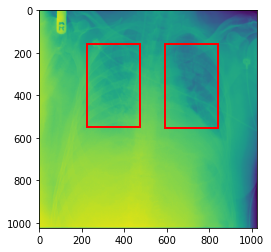

Masks!!


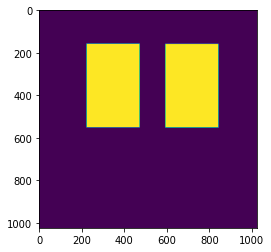

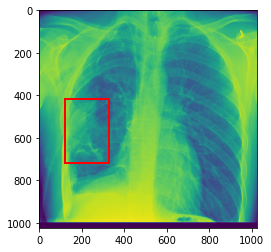

Masks!!


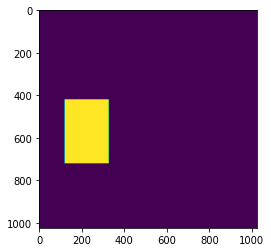

In [ ]:
def get_coordinates_string(coordinates):
    #coordinates_preprocessing
    coordinates_list = re.findall(r'\d+',coordinates)
    coordinates_final_list = []
    count = 0
    for index in range(0,len(coordinates_list),2):
        coordinates_final_list.append(int(coordinates_list[index]))
        count+=1
    
    coordinates_final_list = [coordinates_final_list[index:index+4] for index in range(0, len(coordinates_final_list), 4)]
    return coordinates_final_list
    
no_samples = 2
for index in range(0,no_samples):
    pid = train_data.iloc[index]['Patient_ids']
    coordinates = train_data.iloc[index]['coordinates']
    no_rows = train_data.iloc[index]['No_rows']
    no_columns = train_data.iloc[index]['No_columns']
    coordinates = get_coordinates_string(coordinates)
    path_dicom = os.path.join(train_folder_path,pid+".dcm")
    dicom_obj:pydicom.dataset.FileDataset = pydicom.read_file(path_dicom)
    pixel_values = dicom_obj.pixel_array
    fig,ax = plt.subplots(1)
    masks = np.zeros((1024,1024))
    # Display the image
    ax.imshow(pixel_values)
    for coor in coordinates:
        x1 = coor[0]
        y1 = coor[1]
        x2 = coor[0]+coor[2]
        y2 = coor[1]+coor[3]
        rect = patches.Rectangle((coor[0], coor[1]), coor[2], coor[3], linewidth=2, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        masks[y1:y2, x1:x2] = 1
    
    plt.show()
    print('Masks!!')
    plt.imshow(masks)

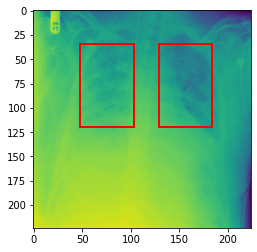

Masks!!


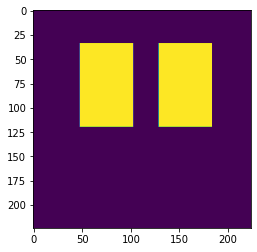

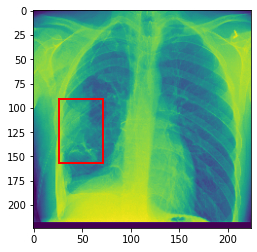

Masks!!


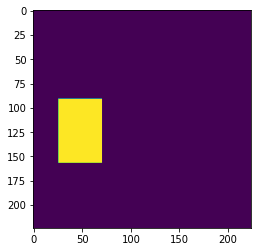

In [ ]:
no_samples = 2
RESIZE_HEIGHT = RESIZE_WIDTH = 224  
for index in range(0,no_samples):
    pid = train_data.iloc[index]['Patient_ids']
    coordinates = train_data.iloc[index]['coordinates']
    no_rows = train_data.iloc[index]['No_rows']
    no_columns = train_data.iloc[index]['No_columns']
    coordinates = get_coordinates_string(coordinates)
    path_dicom = os.path.join(train_folder_path,pid+".dcm")
    dicom_obj:pydicom.dataset.FileDataset = pydicom.read_file(path_dicom)
    pixel_values = dicom_obj.pixel_array
    img_resized = cv2.resize(pixel_values, dsize=(RESIZE_HEIGHT,RESIZE_WIDTH), interpolation=cv2.INTER_CUBIC)
    fig,ax = plt.subplots(1)
    masks = np.zeros((RESIZE_HEIGHT,RESIZE_WIDTH))
    # Display the image
    ax.imshow(img_resized)
    for coor in coordinates:
        x1 = int(coor[0] * (RESIZE_WIDTH/no_columns))
        y1 = int(coor[1]*(RESIZE_HEIGHT/no_rows))
        x2 = int((coor[0]+coor[2])*(RESIZE_WIDTH/1024))
        y2 = int((coor[1]+coor[3])*(RESIZE_HEIGHT/1024))
        rect = patches.Rectangle((x1, y1), x2-x1,y2-y1 , linewidth=2, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        masks[y1:y2, x1:x2] = 1
    
    plt.show()
    print('Masks!!')
    plt.imshow(masks)

### generator for training validation and test set

In [ ]:
def get_train_data():
    for index in range(0,len(train_data)):
        #getting image data
        pid = train_data.iloc[index]['Patient_ids']
        coordinates = train_data.iloc[index]['coordinates']
        no_rows = train_data.iloc[index]['No_rows']
        no_columns = train_data.iloc[index]['No_columns']
        coordinates = get_coordinates_string(coordinates)
        path_dicom = os.path.join(train_folder_path,pid+".dcm")
        dicom_obj:pydicom.dataset.FileDataset = pydicom.read_file(path_dicom)
        pixel_values = dicom_obj.pixel_array
        img_resized = cv2.resize(pixel_values, dsize=(RESIZE_HEIGHT,RESIZE_WIDTH), interpolation=cv2.INTER_CUBIC)
        masks = np.zeros((RESIZE_HEIGHT,RESIZE_WIDTH))
        #updating masks
        for coor in coordinates:
            x1 = int(coor[0] * (RESIZE_WIDTH/no_columns))
            y1 = int(coor[1]*(RESIZE_HEIGHT/no_rows))
            x2 = int((coor[0]+coor[2])*(RESIZE_WIDTH/1024))
            y2 = int((coor[1]+coor[3])*(RESIZE_HEIGHT/1024))
            masks[y1:y2, x1:x2] = 1
        
        #making this as one channel image
        img = np.stack((img_resized,) * 3, -1)
        img = preprocess_input(img)
        yield img,masks

def get_validation_data():
    for index in range(0,len(validation_data)):
        #getting image data
        pid = validation_data.iloc[index]['Patient_ids']
        coordinates = validation_data.iloc[index]['coordinates']
        no_rows = validation_data.iloc[index]['No_rows']
        no_columns = validation_data.iloc[index]['No_columns']
        coordinates = get_coordinates_string(coordinates)
        path_dicom = os.path.join(train_folder_path,pid+".dcm")
        dicom_obj:pydicom.dataset.FileDataset = pydicom.read_file(path_dicom)
        pixel_values = dicom_obj.pixel_array
        img_resized = cv2.resize(pixel_values, dsize=(RESIZE_HEIGHT,RESIZE_WIDTH), interpolation=cv2.INTER_CUBIC)
        masks = np.zeros((RESIZE_HEIGHT,RESIZE_WIDTH))
        #updating masks
        for coor in coordinates:
            x1 = int(coor[0] * (RESIZE_WIDTH/no_columns))
            y1 = int(coor[1]*(RESIZE_HEIGHT/no_rows))
            x2 = int((coor[0]+coor[2])*(RESIZE_WIDTH/1024))
            y2 = int((coor[1]+coor[3])*(RESIZE_HEIGHT/1024))
            masks[y1:y2, x1:x2] = 1

        #making this as one channel image
        img = np.stack((img_resized,) * 3, -1)
        img = preprocess_input(img)
        yield img,masks

def get_test_data():
    for index in range(0,len(test_data)):
        #getting image data
        pid = test_data.iloc[index]['Patient_ids']
        coordinates = test_data.iloc[index]['coordinates']
        no_rows = test_data.iloc[index]['No_rows']
        no_columns = test_data.iloc[index]['No_columns']
        coordinates = get_coordinates_string(coordinates)
        path_dicom = os.path.join(train_folder_path,pid+".dcm")
        dicom_obj:pydicom.dataset.FileDataset = pydicom.read_file(path_dicom)
        pixel_values = dicom_obj.pixel_array
        img_resized = cv2.resize(pixel_values, dsize=(RESIZE_HEIGHT,RESIZE_WIDTH), interpolation=cv2.INTER_CUBIC)
        masks = np.zeros((RESIZE_HEIGHT,RESIZE_WIDTH))
        #updating masks
        for coor in coordinates:
            x1 = int(coor[0] * (RESIZE_WIDTH/no_columns))
            y1 = int(coor[1]*(RESIZE_HEIGHT/no_rows))
            x2 = int((coor[0]+coor[2])*(RESIZE_WIDTH/1024))
            y2 = int((coor[1]+coor[3])*(RESIZE_HEIGHT/1024))
            masks[y1:y2, x1:x2] = 1
        
        #making this as one channel image
        img = np.stack((img_resized,) * 3, -1)
        img = preprocess_input(img)
        yield img,masks
    
batch_size = 16

In [ ]:
train_set_iterator = tf.data.Dataset.from_generator(get_train_data,
                                                    output_signature=(
                                                      tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
                                                      tf.TensorSpec(shape=(224,224), dtype=tf.float64)
                                                      )
                                                    )
val_set_iterator = tf.data.Dataset.from_generator(get_validation_data,
                                                   output_signature=(
                                                      tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
                                                      tf.TensorSpec(shape=(224,224), dtype=tf.float64)
                                                      )
                                                    )
test_set_iterator = tf.data.Dataset.from_generator(get_test_data,
                                                   output_signature=(
                                                      tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
                                                      tf.TensorSpec(shape=(224,224), dtype=tf.float64)
                                                      )
                                                  )
print("Training iterator.........")
train_set_iterator = train_set_iterator.batch(batch_size=batch_size)
for batch in train_set_iterator:
  arr,la = batch
  print(arr.shape)
  print(la.shape)
  break

print("Validation iterator.........")
val_set_iterator = val_set_iterator.batch(batch_size=batch_size) 
for batch in val_set_iterator:
  arr,la = batch
  print(arr.shape)
  print(la.shape)
  break

print("Test iterator.........")
test_set_iterator = test_set_iterator.batch(batch_size=batch_size) 
for batch in test_set_iterator:
  arr,la = batch
  print(arr.shape)
  print(la.shape)
  break

Training iterator.........
(16, 224, 224, 3)
(16, 224, 224)
Validation iterator.........
(16, 224, 224, 3)
(16, 224, 224)
Test iterator.........
(16, 224, 224, 3)
(16, 224, 224)


#### Modelling part

In [ ]:
with strategy.scope():
  model = MobileNet(input_shape=(RESIZE_HEIGHT,RESIZE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet") 
  # Top layer is last layer of the model

  # Make all layers trainable
  for layer in model.layers:
      layer.trainable = True

  # Add all the UNET layers here
  convLayer_112by112 = model.get_layer("conv_pw_1_relu").output
  convLayer_56by56 = model.get_layer("conv_pw_3_relu").output
  convLayer_28by28 = model.get_layer("conv_pw_5_relu").output
  convLayer_14by14 = model.get_layer("conv_pw_11_relu").output
  convLayer_7by7 = model.get_layer("conv_pw_13_relu").output
  # The last layer of mobilenet model is of dimensions (7x7x1024)

  # Start upsampling from 7x7 to 14x14 ...up to 224x224 to form UNET
  # concatinate with the original image layer of the same size from MobileNet
  x = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
  x = Concatenate()([UpSampling2D()(x), convLayer_28by28])
  x = Concatenate()([UpSampling2D()(x), convLayer_56by56])
  x = Concatenate()([UpSampling2D()(x), convLayer_112by112])
  x = UpSampling2D(name="unet_last")(x) # upsample to 224x224

  # Add classification layer
  x = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(x)
  x = Reshape((RESIZE_HEIGHT,RESIZE_WIDTH))(x) 

  mobile_net_unet = Model(inputs=model.input, outputs=x)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [ ]:
learning_rate = 1e-5
batch_size = 16
epochs = 500
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
with strategy.scope():
  mobile_net_unet.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

save_model_path = os.path.join(os.getcwd(),
                               'save_training_weights',
                               'mobile_net',
                               'best_weights.h5')

early_stopping = EarlyStopping(monitor='loss',mode = "min",patience=12)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-9, verbose=1)
model_checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(save_model_path, 
                                                    save_best_only=True,
                                                    save_weights_only=True, 
                                                    monitor='val_dice_coefficient', 
                                                    mode='max', 
                                                    verbose=1)

history_logges_path=  os.path.join(os.getcwd(),
                                   'save_training_weights',
                                   'mobile_net',
                                   "loggs.csv")

history_logger=tf.keras.callbacks.CSVLogger(history_logges_path, separator=",", append=True)
import numpy as np
import tensorflow as tf
np.random.seed(12)
tf.random.set_seed(12)

In [ ]:

with strategy.scope():
  history = mobile_net_unet.fit(
    train_set_iterator,
    validation_data = val_set_iterator,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping,model_checkpoint,reduce_lr,history_logger],
    workers = 2*batch_size,
    verbose=1,
    shuffle=True,
    use_multiprocessing=False
  )

Epoch 1/500


ResourceExhaustedError: ignored